In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import datetime as dtm
import vel_tools as vt

from salishsea_tools import nc_tools, viz_tools

%matplotlib inline
mpl.rcParams.update({'font.size': 12})
mpl.rcParams["axes.formatter.useoffset"] = False

warnings.simplefilter("ignore")

In [280]:
def ONC_comparisons(ax, datein, station, u_grid, v_grid, depth_grid, t=[0], maskval=0):
    '''
    '''
    
    if station == 'east':
        i = 283
        j = 416
    elif station == 'central':
        i = 266
        j = 424
    
    # ----- LOAD ONC VELOCITY PROFILES -----
    timestamp, depth, u, v = vt.load_ADCP(datein, station)
    
    # ONC time average
    u_ADCP = u[:, t[0]*2]
    v_ADCP = v[:, t[0]*2]
    
    # NEMO time average
    u_tzyx = np.ma.masked_values(u_grid[t, :, j, i].mean(axis=0), maskval)
    v_tzyx = np.ma.masked_values(v_grid[t, :, j, i].mean(axis=0), maskval)
    
    # Transform velocities from grid to map coords
    theta_rad = 29 * np.pi / 180
    u_ONC =  u_ADCP * np.cos(theta_rad) + v_ADCP * np.sin(theta_rad)
    v_ONC = -u_ADCP * np.sin(theta_rad) + v_ADCP * np.cos(theta_rad)
    
    
    ax.plot(v_tzyx, depth_grid, 'g-')
    ax.plot(v_ADCP, depth, 'b-')
    ax.invert_yaxis()

In [204]:
def plot_tides(ax, datein, t=0, version=3.4, station='PointAtkinson'):
    '''
    '''
    
    # Load NEMO outputs at station
    PA = vt.load_NEMO_stations(datein, version=version, station_name=station)
    
    # Construct time objects for timeseries
    timestamps = nc_tools.timestamp(PA, np.arange(PA.variables['time_counter'].shape[0]), version=version)
    PA_time = [timestamp.datetime for timestamp in timestamps]

    # Plot tides
    ax.plot(PA_time, PA.variables['sossheig'][:, 0, 0], 'k-')
    ax.plot(PA_time[t*4], PA.variables['sossheig'][t*4, 0, 0], 'ko', markersize=12)

In [306]:
def make_plots(datein, t=[0], zlevel=[0], ylocn=455, section_slice=np.arange(238, 318),
               map_bounds=np.array([-124, -123, 48.5, 49.7])):
    '''Plot nowcast and nowcast-green velocity fields
    '''
    
    # Plotting parameters
    version = 3.6
    
    # ----- LOAD WIND FORCING -----
    wind_OP, wind_RS = vt.load_wind(datein)
    lat_wind = wind_OP.variables['nav_lat']
    lon_wind = wind_OP.variables['nav_lon']
    u_wind   = wind_OP.variables['u_wind']
    v_wind   = wind_OP.variables['v_wind']
    SLP      = wind_OP.variables['atmpres']
    
    # Make figure
    fig, ax = plt.subplots(1, 6, figsize=(15, 20))
    gs = mpl.gridspec.GridSpec(4, 3, width_ratios=[2.3, 1, 1], height_ratios=[1, 1, 1.5, .45])
    ax[0] = plt.subplot(gs[:2, 0])
    ax[1] = plt.subplot(gs[ 0, 1:])
    ax[2] = plt.subplot(gs[ 1, 1:])
    ax[3] = plt.subplot(gs[ 2:, 0])
    ax[4] = plt.subplot(gs[ 2, 1])
    ax[5] = plt.subplot(gs[ 2, 2])
        
    # ----- LOAD NEMO RESULTS -----
    u_vel, v_vel, w_vel, tracers = vt.load_NEMO_OP(datein, version=version, avg='h')
    
    # Define subfields
    ugrid     = u_vel.variables['vozocrtx']
    vgrid     = v_vel.variables['vomecrty']
    zlevels   = u_vel.variables['depthu']
    lats      = u_vel.variables['nav_lat']
    lons      = u_vel.variables['nav_lon']
    tindex    = u_vel.variables['time_counter']
    timestamp = nc_tools.timestamp(u_vel, t, version=version)
    
    # ----- PLOT SURFACE CURRENTS -----
    vt.plot_horz_currents(ax[0], lons, lats, ugrid, vgrid, t=t, zlevel=zlevel)
    vt.plot_wind(ax[0], lon_wind, lat_wind, u_wind, v_wind, t=t)
    ax[0].plot(lons[ylocn, section_slice], lats[ylocn, section_slice],
                  linestyle='solid', linewidth=3, color='black', label='Section Line')
    ax[0].plot(lons[416, 283], lats[416, 283], 'ko', markersize=8, label='ONC East')
    ax[0].plot(lons[424, 266], lats[424, 266], 'ko', markersize=8, label='ONC Central')
    ax[0].plot(-123.27, 49.33, 'ko', markersize=8, label='Point Atkinson')
    ax[0].set_xlim(map_bounds[0:2])
    ax[0].set_ylim(map_bounds[2:4])
    ax[0].set_title('NEMO {version:.1f} surface currents, GEM HRDPS 10m winds'.format(version=version))
    
    # ----- PLOT ALONGSHORE CURRENTS -----
    mesh = vt.plot_cross_section(ax[3], lons, vgrid, zlevels, ylocn, section_slice, t=t,
                                 crange=np.array([-.5, .5]))
    ax[3].plot(np.array([lons[416, 283], lons[416, 283]]), np.array([0, 450]),
                  linestyle='solid', linewidth=3, color='black', label='ONC East')
    ax[3].plot(np.array([lons[424, 266], lons[424, 266]]), np.array([0, 450]),
                  linestyle='solid', linewidth=3, color='black', label='ONC Central')
    ax[3].set_xticks(np.arange(-123.5, -123.3, 0.1))
    cbar = fig.colorbar(mesh, ax=ax[3], orientation='horizontal')
    cbar.set_ticks(np.arange(-.5, .501, .1))
    cbar.set_label('Alongstrait Velocity [m/s]')
    ax[3].set_xlim(-123.55, -123.25)
    ax[3].set_ylim(400, 0)
    ax[3].set_ylabel('Depth [m]')

        
    
    plot_tides(ax[1], datein, t=t[0], version=version, station='PointAtkinson')
    ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M"))
    ax[1].set_title('NEMO SSH [m] at Point Atkinson')
    ax[1].set_ylim(-2.5, 1.5)
    ax[1].annotate('{}'.format(timestamp.format('DD-MMM-YYYY HH:MM')), xy=(.7, .05), xycoords='axes fraction')
    
    plot_tides(ax[2], datein, t=t[0], version=version, station='Victoria')
    ax[2].xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M"))
    ax[2].set_title('NEMO SSH [m] at Victoria')
    ax[2].set_ylim(-2.5, 1.5)
    
    ONC_comparisons(ax[4], datein, 'central', ugrid, vgrid, zlevels, t=t)
    ax[4].plot(np.array([0, 0]), np.array([0, 450]), 'k--')
    ax[4].set_xlim(-.5, .5)
    ax[4].set_ylim(400, 0)
    ax[4].set_title('ONC Central Node')
    ax[4].set_xlabel('Alongstrait Velocity [m/s]')
    
    ONC_comparisons(ax[5], datein, 'east', ugrid, vgrid, zlevels, t=t)
    ax[5].plot(np.array([0, 0]), np.array([0, 450]), 'k--')
    ax[5].set_xlim(-.5, .5)
    ax[5].set_ylim(400, 0)
    ax[5].set_title('ONC East Node')
    ax[5].legend(['NEMO', 'ONC'], loc=4)
    ax[5].set_xlabel('Alongstrait Velocity [m/s]')

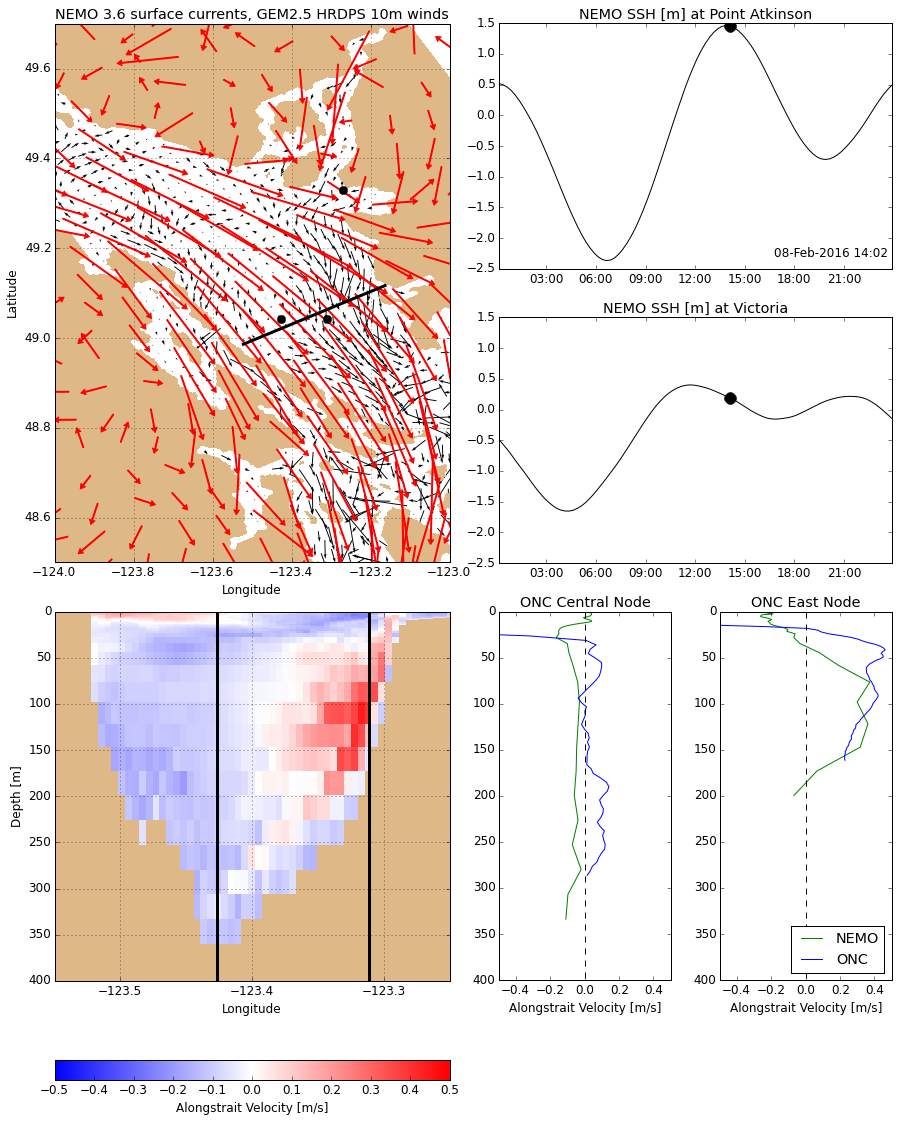

In [314]:
# Plotting parameters
# ------ T = 0 ----------
t             = [14]
zlevel        = [0]
ylocn         = 420
section_slice = np.arange(245, 315)
map_bounds    = np.array([-124, -123, 48.5, 49.7])

# Make Plots
make_plots('2016-feb-08', t=t, zlevel=zlevel, ylocn=ylocn, section_slice=section_slice, map_bounds=map_bounds)

plt.savefig('NEMO_currents.eps', bbox_inches='tight')